# MNIST

Ce notebook est une implémentation du modèle LeNet-5: http://yann.lecun.com/exdb/mnist/

Il présente aussi des parties sur des exemples d'attaques du modèle et d'explicabilité des résultats (LIME)

In [ ]:
# Ref file format, ...: http://yann.lecun.com/exdb/mnist/
# train-images-idx3-ubyte.gz:  training set images (9912422 bytes)
! curl http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz -o train-images-idx3-ubyte.gz
# train-labels-idx1-ubyte.gz:  training set labels (28881 bytes)
! curl http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz -o train-labels-idx1-ubyte.gz
# t10k-images-idx3-ubyte.gz:   test set images (1648877 bytes)
! curl http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz -o t10k-images-idx3-ubyte.gz
# t10k-labels-idx1-ubyte.gz:   test set labels (4542 bytes) 
! curl http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz -o t10k-labels-idx1-ubyte.gz

In [ ]:
! python -m gzip -d train-images-idx3-ubyte.gz
! python -m gzip -d train-labels-idx1-ubyte.gz
! python -m gzip -d t10k-images-idx3-ubyte.gz
! python -m gzip -d t10k-labels-idx1-ubyte.gz

In [ ]:
!pip install lime

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from array import array
import matplotlib.pyplot as plt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

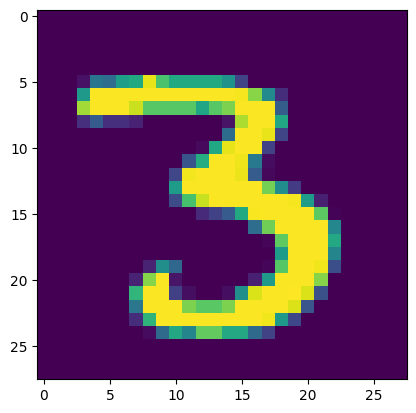

In [2]:
def read_images(filename):
    with open(filename, "rb") as f_train_image:
        train_image = f_train_image.read()

    assert int.from_bytes(train_image[:4], byteorder="big") == 2051, "Invalid magic number for the TRAINING SET IMAGE FILE"

    img_width = 28
    img_height = 28
    img_size = img_width * img_height
    img_offset = 16

    number_of_examples = int.from_bytes(train_image[4:8], byteorder="big")

    def img_to_torch(i):
        return torch.tensor(list(train_image[img_offset + i * img_size:img_offset + (i+1) * img_size]), dtype=torch.float)\
            .to(device)\
            .reshape(1, img_height, img_width)

    inputs_set = [img_to_torch(i) for i in range(number_of_examples)]
    return inputs_set

inputs_set = read_images("train-images-idx3-ubyte")
t_inputs = torch.stack(inputs_set)
img_index = 12
plt.imshow(t_inputs[img_index, 0])

In [3]:
def read_labels(filename):
    with open(filename, "rb") as f_train_label:
        train_label = f_train_label.read()

    assert int.from_bytes(train_label[:4], byteorder="big") == 2049, "Invalid magic number for the TRAINING SET IMAGE FILE"

    label_offset = 0x08

    t_labels = torch.tensor(list(train_label[label_offset:]))
    labels_set=F.one_hot(t_labels).type(torch.float).to(device)
    return t_labels, labels_set

t_labels, labels_set = read_labels("train-labels-idx1-ubyte")
labels_set[img_index], torch.argmax(labels_set[img_index])

(tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]), tensor(3))

In [4]:
# http://cedric.cnam.fr/~thomen/cours/STA211/_images/LeNet5.png
class LeNet5(nn.Module):
    def __init__(self):
        super().__init__()
        self.C1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=(5, 5), padding=2)
        self.S2 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        self.C3 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=(5, 5), padding=0)
        self.S4 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        self.C5 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=(5, 5), padding=0)
        self.F6 = nn.Linear(120, 84)
        self.F7 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.S2(F.relu(self.C1(x)))
        x = self.S4(F.relu(self.C3(x)))
        x = torch.tanh(self.C5(x))
        x = nn.Flatten()(x)
        x = torch.sigmoid(self.F6(x))
        x = F.softmax(self.F7(x), dim=1)
        return x

In [5]:
def accuracy(net, t_inputs, t_labels):
    t_outputs = net(t_inputs)
    t_outputs = torch.argmax(t_outputs, dim=1)
    train_acc = torch.sum(t_outputs == t_labels)
    return 100 * train_acc / t_outputs.shape[0]

In [6]:
import torch.optim as optim
from tqdm import tqdm

trainset = list(zip(inputs_set, labels_set))

net = LeNet5()
net.train()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

batch_size = 32
epoch_size = 10

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)
losses = []
accuracies = []
for epoch in tqdm(range(epoch_size)):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        losses.append(loss.item())
    accuracies.append(accuracy(net, t_inputs, t_labels))
print('Training Done')

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [02:21<00:00, 14.12s/it]

Training Done


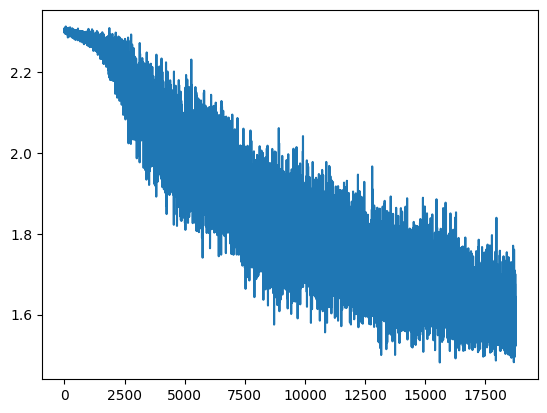

In [7]:
plt.plot(losses)

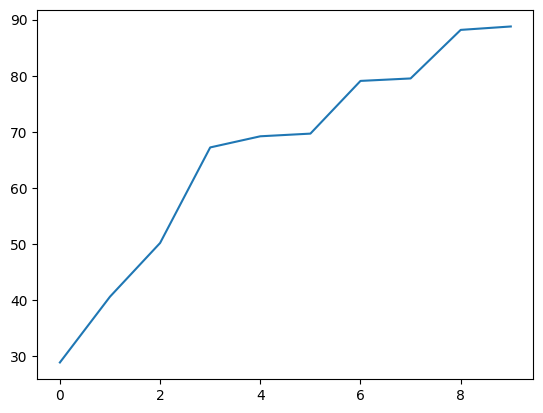

In [8]:
net.eval()
with torch.no_grad():
    plt.plot(accuracies)
    accuracy(net, t_inputs, t_labels)

In [11]:
test_inputs_set = read_images("t10k-images-idx3-ubyte")
test_inputs = torch.stack(test_inputs_set)
test_labels, test_labels_set = read_labels("t10k-labels-idx1-ubyte")
with torch.no_grad():
    print(accuracy(net, test_inputs, test_labels))

tensor(88.8100)


# Attack on the model

References:
 - [Adversarial Examples: Attacks and Defenses for Deep Learning](https://www.researchgate.net/publication/321860123_Adversarial_Examples_Attacks_and_Defenses_for_Deep_Learning)

(<matplotlib.image.AxesImage at 0x1287fd25400>, tensor(3), tensor(3))

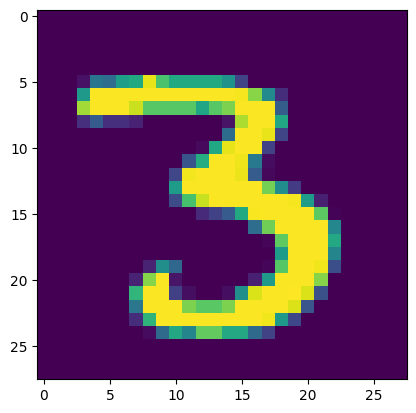

In [12]:
current_img = 12
with torch.no_grad():
    y_hat = torch.argmax(net(t_inputs[current_img].unsqueeze(0)))
plt.imshow(t_inputs[current_img,0].numpy()), t_labels[current_img], y_hat

(<matplotlib.image.AxesImage at 0x12888a77550>, tensor(6), tensor(6))

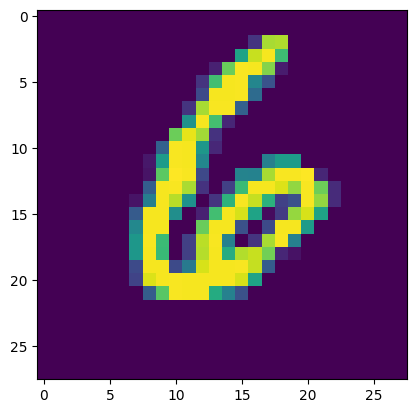

In [13]:
delta_img = 13
with torch.no_grad():
    y_hat = torch.argmax(net(t_inputs[delta_img].unsqueeze(0)))
plt.imshow(t_inputs[delta_img,0].numpy()), t_labels[delta_img], y_hat

In [14]:
def attack(current_img):
    x_delta = torch.tensor(test_inputs[current_img], requires_grad=True)
    optimizer.zero_grad()
    y = test_labels[current_img].unsqueeze(0)
    y_hat = net(x_delta.unsqueeze(0))
    loss = criterion(y_hat, y)
    external_grad = torch.tensor(1.)
    loss.backward(gradient=external_grad, retain_graph=True)
    return (x_delta + 0.25 * torch.sign(x_delta.grad)).detach()

C:\Users\pfkc8924\AppData\Local\Temp\ipykernel_12052\574776953.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_delta = torch.tensor(test_inputs[current_img], requires_grad=True)


Expected label for example 495: 8
Predicted label for example 495: 8 (tensor([[2.3799e-01, 7.8156e-03, 7.1886e-02, 5.1320e-03, 1.0768e-02, 8.5157e-03,
         3.1751e-01, 3.2802e-04, 3.3754e-01, 2.5124e-03]],
       grad_fn=<SoftmaxBackward0>))
Predicted label for perturbated example: 6 (tensor([[2.4147e-01, 7.6616e-03, 7.2178e-02, 5.3983e-03, 1.0005e-02, 8.3484e-03,
         3.2741e-01, 3.1493e-04, 3.2490e-01, 2.3142e-03]],
       grad_fn=<SoftmaxBackward0>))


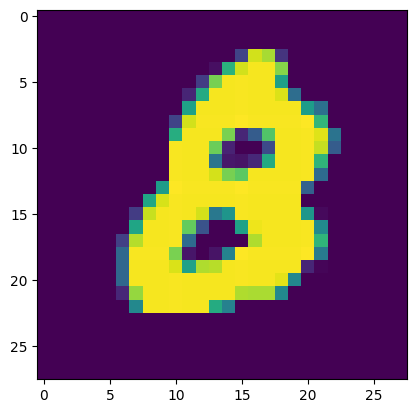

In [74]:
initial_index = 0
# initial_index = 708

for i in range(initial_index, len(test_labels)):
    x_origin = test_inputs[i]
    y_softmax = net(x_origin.unsqueeze(0))
    y = torch.argmax(y_softmax)
    if y == test_labels[i]:
        x_attack = attack(i)
        y_hat_attack_softmax = net(x_attack.unsqueeze(0))
        y_hat_attack = torch.argmax(y_hat_attack_softmax)
        if y_hat_attack != y:
            plt.imshow(x_attack[0].numpy())
            print(f"Expected label for example {i}: {test_labels[i]}")
            print(f"Predicted label for example {i}: {y} ({y_softmax})")
            print(f"Predicted label for perturbated example: {y_hat_attack} ({y_hat_attack_softmax})")
            break

In [75]:
x_origin[0, 0, 0], x_attack[0, 0, 0], torch.linalg.norm(x_origin - x_attack)

(tensor(0.), tensor(0.2500), tensor(7.))

# Explaining results

Nous allons utiliser le [framework LIME (pour "Local Interpretable Model-agnostic Explanations")](https://github.com/marcotcr/lime) pour analyser les résultats obtenus.

L'exemple est basé sur le [tutorial de LIME](https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20images%20-%20Pytorch.ipynb)

In [76]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

model = net

def batch_predict(images):
    model.eval()
    batch = torch.stack([torch.from_numpy(i[:,:,0]).unsqueeze(0) for i in images], dim=0)
    batch = batch.to(device)
    
    probs = model(batch)
    # probs = torch.argmax(logits, dim=1)
    
    return probs.detach().cpu().numpy()



explainer = lime_image.LimeImageExplainer()

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


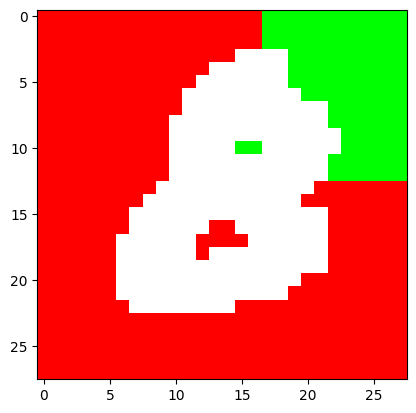

In [100]:
explanation = explainer.explain_instance(x_origin[0].numpy(), 
                                         batch_predict, # classification function
                                         top_labels=5, 
                                         hide_color=0,
                                         num_samples=1000)
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0],
                                            positive_only=False,
                                            num_features=10,
                                            hide_rest=False)
#img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(temp)

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


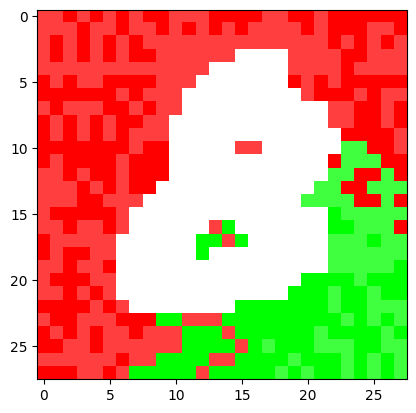

In [99]:
explanation = explainer.explain_instance(x_attack[0].numpy(), 
                                         batch_predict, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000)
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0],
                                            positive_only=False,
                                            num_features=10,
                                            hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(temp)

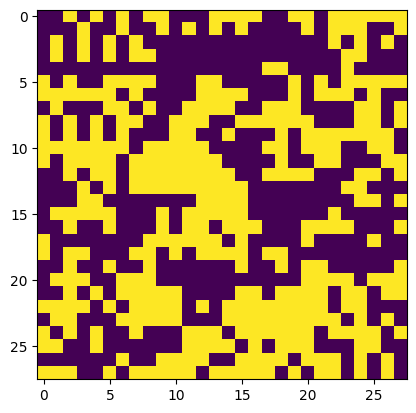

In [90]:
plt.imshow((x_origin - x_attack)[0].numpy())